<a href="https://colab.research.google.com/github/limaih/text_generation/blob/main/TextGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text Generation
Text Generation is a type of Language Modelling problem. Language Modelling is the core problem for a number of of natural language processing tasks such as speech to text, conversational system, and text summarization. A trained language model learns the likelihood of occurrence of a word based on the previous sequence of words used in the text. Language models can be operated at character level, n-gram level, sentence level or even paragraph level. These models can, for example, fill in incomplete text or paraphrase.

In this practical, we will use Python and the concept of text generation to build a machine learning model that can generate plausible text sequences for a given problem. Given a sequence of characters from this data ("Shakespear"), train a model to predict the next character in the sequence ("e"). Longer sequences of text can be generated by calling the model repeatedly.

This practical is an adaption from: https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

<div class="alert alert-block alert-danger">
<b>Tip:Set the runtime in colab to GPU for faster training.</b>
</div>

## Import Libraries
As the first step, we need to import the required libraries:
~~~Python
import sys
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
~~~

## Load the dataset
In this practical we will use the **Alice's Adventures in Wonderland by Lewis Carroll** as the dataset. You can download this book (**wonderland.txt**)from: https://github.com/limaih/text_generation/blob/main/wonderland.txt and place it in your working directory.

We will load the ASCII text for the book into memory and convert all of the characters to lowercase to reduce the vocabulary the network must learn.

~~~ Python
# load ascii text and covert to lowercase
filename = "wonderland.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()
~~~

Now that the book is loaded, we must prepare the data for modeling by the neural network. We cannot model the characters directly; instead, we must convert the characters to integers.

We can do this easily by first creating a set of all of the distinct characters in the book, then creating a map of each character to a unique integer. Also, when preparing the mapping of unique characters to integers, we must also create a reverse mapping that you can use to convert the integers back to characters so that we can understand the predictions.

~~~Python
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars)) #reverse mapping
~~~

Now that the book has been loaded and the mapping prepared, you can summarize the dataset.

~~~Python
n_chars = len(raw_text)
n_vocab = len(chars)
print ("Total Characters: ", n_chars)
print ("Total Vocab: ", n_vocab)
~~~

We can see the book has just under 150,000 characters, and when converted to lowercase, there are only 49 distinct characters in the vocabulary for the network to learn—much more than the 26 in the alphabet.

We now need to define the training data for the network. There is a lot of flexibility in how you choose to break up the text and expose it to the network during training.

In this practical, we will split the book text up into subsequences with a fixed length of 100 characters, an arbitrary length. We could easily split the data by sentences, padding the shorter sequences and truncating the longer ones.

Each training pattern of the network comprises 100 time steps of one character (X) followed by one character output (y). When creating these sequences, you slide this window along the whole book one character at a time, allowing each character a chance to be learned from the 100 characters that preceded it (except the first 100 characters, of course).

For example, if the sequence length is 5 (for simplicity), then the first two training patterns would be as follows:

CHAPT -> E

HAPTE -> R

As we split the book into these sequences, we will convert the characters to integers using the lookup table we have prepared earlier.

~~~Python
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
  seq_in = raw_text[i:i + seq_length]
  seq_out = raw_text[i + seq_length]
  dataX.append([char_to_int[char] for char in seq_in])
  dataY.append(char_to_int[seq_out])

n_patterns = len(dataX)
print ("Total Patterns: ", n_patterns)
~~~

Now that we have prepared our training data, we need to transform it to be suitable for use with Keras.

First, we must transform the list of input sequences into the form [samples, time steps, features] expected by an LSTM network.

Next, we need to rescale the integers to the range 0-to-1 to make the patterns easier to learn by the LSTM network using the sigmoid activation function by default.

Finally, we need to convert the output patterns (single characters converted to integers) into a one-hot encoding. This is so that you can configure the network to predict the probability of each of the 49 different characters in the vocabulary (an easier representation) rather than trying to force it to predict precisely the next character. Each y value is converted into a sparse vector with a length of 49, full of zeros, except with a 1 in the column for the letter (integer) that the pattern represents.

For example, when “n” (integer value 31) is one-hot encoded, it looks as follows:
<blockquote>
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
</blockquote>

~~~Python
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))

# normalize
X = X / float(n_vocab)

# one hot encode the output variable
y = to_categorical(dataY)
~~~

Now we can obtain the input vector X and the label vector Y which can be used for the training purposes.

##LSTMs for Text Generation

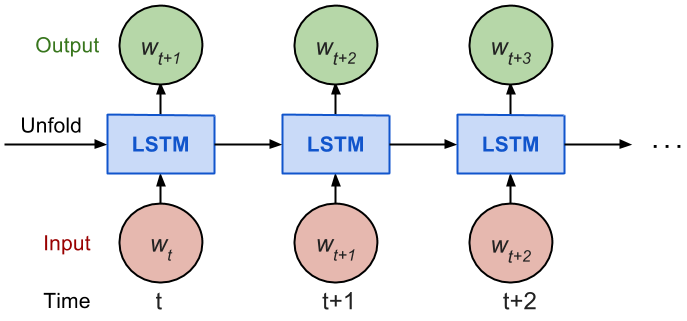

Unlike Feed-forward neural networks in which activation outputs are propagated only in one direction, the activation outputs from neurons propagate in both directions (from inputs to outputs and from outputs to inputs) in Recurrent Neural Networks. This creates loops in the neural network architecture which acts as a ‘memory state’ of the neurons. This state allows the neurons an ability to remember what have been learned so far.

The memory state in RNNs gives an advantage over traditional neural networks but a problem called Vanishing Gradient is associated with them. In this problem, while learning with a large number of layers, it becomes really hard for the network to learn and tune the parameters of the earlier layers. To address this problem, A new type of RNNs called LSTMs (Long Short Term Memory) Models have been developed.

LSTMs have an additional state called ‘cell state’ through which the network makes adjustments in the information flow. The advantage of this state is that the model can remember or forget the leanings more selectively.

1. **Input Layer**: Takes the sequence of characters as input
2. **LSTM Layer**: Computes the output using LSTM units.
3. **Dropout Layer**: A regularisation layer which randomly turns-off the activations of some neurons in the LSTM layer. It helps in preventing over fitting. (Optional Layer)
4. **Output Layer**: Computes the probability of the best possible next character as output

Here, we will define a single hidden LSTM layer with 256 memory units. The network uses dropout with a probability of 20. The output layer is a Dense layer using the softmax activation function to output a probability prediction for each of the 49 characters between 0 and 1.

The problem is really a single character classification problem with 49 classes and, as such, is defined as optimizing the log loss (cross entropy) using the ADAM optimization algorithm for speed.

~~~Python
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
~~~

There is no test dataset. We are modeling the entire training dataset to learn the probability of each character in a sequence.

We are not interested in the most accurate (classification accuracy) model of the training dataset. This would be a model that predicts each character in the training dataset perfectly. Instead, we are interested in a generalization of the dataset that minimizes the chosen loss function. We are seeking a balance between generalization and overfitting but short of memorization.

The network is slow to train. Because of the slowness and the optimization requirements, we will use model checkpointing to record all the network weights to file each time an improvement in loss is observed at the end of the epoch. Afterwhich, we will use the best set of weights (lowest loss) to instantiate our generative model in the next section.

~~~Python
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
~~~

Now we will fit our model to the data. Here,  we will use a modest number of 20 epochs and a large batch size of 128 patterns.

~~~Python
model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)
~~~

**Note:** The results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

After running the example, we should have a number of weight checkpoint files in the local directory.

For example, when this example was run, you can see below the checkpoint with the smallest loss that was achieved.

`weights-improvement-20-2.0432.hdf5`

The network loss decreased almost every epoch, so the network could likely benefit from training for many more epochs.

In the next section, we will look at using this model to generate new text sequences.

##Generating Text with an LSTM Network
Generating text using the trained LSTM network is relatively straightforward.

First, you will load the data and define the network in exactly the same way, except the network weights are loaded from a checkpoint file, and the network does not need to be trained.

~~~Python
# load the network weights
filename = "weights-improvement-20-2.0432.hdf5" #replace with the smallest loss file
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')
~~~

In [ ]:
# load the network weights
filename = "weights-improvement-20-2.0432.hdf5" #replace with the smallest loss file
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

The simplest way to use the Keras LSTM model to make predictions is to first start with a seed sequence as input, generate the next character, then update the seed sequence to add the generated character on the end and trim off the first character. This process is repeated for as long as you want to predict new characters (e.g., a sequence of 1,000 characters in length).

Let's pick a random input pattern as our seed sequence, then print generated characters as we generate them.

~~~Python
def get_randomtext(dataX):
  # pick a random seed
  start = np.random.randint(0, len(dataX)-1)
  pattern = dataX[start]

  return pattern

pattern = get_randomtext(dataX)

# generate characters
for i in range(1000):
  x = np.reshape(pattern, (1, len(pattern), 1))
  x = x / float(n_vocab)
  prediction = model.predict(x, verbose=0)
  index = np.argmax(prediction)
  result = int_to_char[index]
  seq_in = [int_to_char[value] for value in pattern]
  sys.stdout.write(result)
  pattern.append(index)
  pattern = pattern[1:len(pattern)]

print("\nDone.")
~~~

Some observations about the generated text.

* It generally conforms to the line format observed in the original text of fewer than 80 characters before a new line.
* The characters are separated into word-like groups, and most groups are actual English words (e.g., “the,” “little,” and “was”), but many are not (e.g., “lott,” “tiie,” and “taede”).
* Some of the words in sequence make sense(e.g., “and the white rabbit“), but many do not (e.g., “wese tilel“).

The fact that this character-based model of the book produces output like this is very impressive. It gives you a sense of the learning capabilities of LSTM networks.

However, the results are not perfect.

In the next section, we will look at improving the quality of results by developing a much larger LSTM network.

##Larger LSTM Recurrent Neural Network
We got results, but not excellent results in the previous section. Now, we can try to improve the quality of the generated text by creating a much larger network.

We will keep the number of memory units the same at 256 but add a second layer. We will also change the filename of the checkpointed weights so that we can tell the difference between weights for this network and the previous (by appending the word “bigger” in the filename).

Finally, we will increase the number of training epochs from 20 to 50 and decrease the batch size from 128 to 64 to give the network more of an opportunity to be updated and learn.

~~~Python
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# define the checkpoint
filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# fit the model
model.fit(X, y, epochs=50, batch_size=64, callbacks=callbacks_list)
~~~

After running this example, we may achieve a loss of about 1.2. For example, the best result achieved from running this model was stored in a checkpoint file with the name:

`weights-improvement-50-1.2391-bigger.hdf5`

This achieved a loss of 1.2390 at epoch 50.

As in the previous section, we can use this best model from the run to generate text.

~~~Python
# load the network weights
filename = "weights-improvement-50-1.2391-bigger.hdf5" #replace with the smallest loss file
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

# generate characters
for i in range(1000):
  x = np.reshape(pattern, (1, len(pattern), 1))
  x = x / float(n_vocab)
  prediction = model.predict(x, verbose=0)
  index = np.argmax(prediction)
  result = int_to_char[index]
  seq_in = [int_to_char[value] for value in pattern]
  sys.stdout.write(result)
  pattern.append(index)
  pattern = pattern[1:len(pattern)]

print("\nDone.")
~~~

We can see that there are generally fewer spelling mistakes, and the text looks more realistic but is still quite nonsensical.

For example, the same phrases get repeated again and again, like “said to herself” and “little.” Quotes are opened but not closed.

These are better results, but there is still a lot of room for improvement.

###Ways to improve the model:
- Predict fewer than 1,000 characters as output for a given seed
- Remove all punctuation from the source text and, therefore, from the models’ vocabulary
- Try a one-hot encoding for the input sequences
- Train the model on padded sentences rather than random sequences of characters
- Increase the number of training epochs to 100 or many hundreds
- Add dropout to the visible input layer and consider tuning the dropout percentage
- Tune the batch size; try a batch size of 1 as a (very slow) baseline and larger sizes from there
- Add more memory units to the layers and/or more layers
- Experiment with scale factors (temperature) when interpreting the prediction probabilities
- Change the LSTM layers to be “stateful” to maintain state across batches